In [1]:
from __future__ import print_function

import os

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers

from binary_ops import binary_tanh as binary_tanh_op
from binary_layers import BinaryDense, Clip

Using TensorFlow backend.


In [2]:
class DropoutNoScale(Dropout):
    '''Keras Dropout does scale the input in training phase, which is undesirable here.
    '''
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed) * (1 - self.rate)
            return K.in_train_phase(dropped_inputs, inputs,
                                    training=training)
        return inputs

def binary_tanh(x):
    return binary_tanh_op(x)

In [3]:
class VGGbinarized_cifar10:
    def __init__(self, train=True, epochs=250, path='saved_models', weights_path=None, weights_transfer_l=None):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = [32,32,3]
        
        save_dir = os.path.join(os.getcwd(), path)
        model_name = 'VGGbinarized_cifar10_model.{epoch:03d}-{val_acc:.2f}.h5'
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        self.filepath = os.path.join(save_dir, model_name)
        
        print('Trained weights saving path ', self.filepath)
        

        self.model = self.build_model()
        if weights_transfer_l != None:
            print('Loading weights for transfer learning from ', weights_transfer_l)
            self.model.load_weights(weights_transfer_l)
            self.model = self.binarize(all_trainable=False)
        if weights_path != None:
            self.model = self.binarize(all_trainable=True)
            print('Loading weights from ', weights_path)
            self.model.load_weights(weights_path)
        else:
            self.model = self.binarize(all_trainable=True)
        
        if train:
            self.model = self.train(epochs)


    def build_model(self):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = Sequential()
        weight_decay = self.weight_decay

        model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten(name='Flatten'))
        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))
        return model
    
    def binarize(self, all_trainable=False):
        model = self.model
        if (all_trainable == False):
            for layer in model.layers:
                layer.trainable = False
        
        last = model.get_layer('Flatten').output
        
        x = BinaryDense(512, H='Glorot', kernel_lr_multiplier='Glorot', use_bias=False) (last)
        x = Activation(binary_tanh)(x)
        
        x = BinaryDense(512, H='Glorot', kernel_lr_multiplier='Glorot', use_bias=False) (x)
        x = Activation(binary_tanh)(x)
        
        x = DropoutNoScale(0.5)(x)
        x = BinaryDense(10, H='Glorot', kernel_lr_multiplier='Glorot', use_bias=False)(x)
#       x = Activation(binary_tanh)(x)
        
        model = Model(model.input, x)
        return model
    
    def normalize(self,X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        
#         X_train /= 255
#         X_test /= 255
        return X_train, X_test

    def normalize_production(self,x):
        #this function is used to normalize instances in production according to saved training set statistics
        # Input: X - a training set
        # Output X - a normalized training set according to normalization constants.

        #these values produced during first training and are general for the standard cifar10 training set normalization
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    def predict(self,x,normalize=True,batch_size=50):
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x,batch_size)
    
    def train(self, epochs=None, model=None):
        #training parameters
        batch_size = 128
        maxepochs = 250 
        if (epochs != None):
            maxepochs = epochs
        if model == None:
            model = self.model
            
        print('Starting training for %s epochs'%maxepochs)
            
        learning_rate = 0.1
        lr_decay = 1e-6
        lr_drop = 20
        # The data, shuffled and split between train and test sets:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train, x_test = self.normalize(x_train, x_test)

        y_train = keras.utils.to_categorical(y_train, self.num_classes)
        y_test = keras.utils.to_categorical(y_test, self.num_classes)

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

        #data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=4,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=4,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        #optimization details
        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
        model.compile(loss='squared_hinge', optimizer=sgd,metrics=['accuracy'])

        checkpoint = ModelCheckpoint(filepath=self.filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

        # training process in a for loop with learning rate drop every 25 epochs.
        historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=maxepochs,
                            validation_data=(x_test, y_test),callbacks=[reduce_lr, checkpoint],verbose=1)
#         model.save_weights('cifar10vgg.h5')
        return model

In [6]:
model_handle = VGGbinarized_cifar10(train=False, weights_transfer_l='../baselines/saved_models/VGG_cifar10_model.277-0.94.h5')
model_handle.model.summary()

Trained weights saving path  /root/workspace/bnn_p4/BaNaNa-split-binarization/binarized/saved_models/VGGbinarized_cifar10_model.{epoch:03d}-{val_acc:.2f}.h5
Loading weights for transfer learning from  ../baselines/saved_models/VGG_cifar10_model.277-0.94.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14_input (InputLayer) (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_21 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 64)        0         
_________________

In [7]:
model_handle.train(epochs=20)

Starting training for 20 epochs
Epoch 1/20
390/390 [==============================] - 32s 83ms/step - loss: 1.0768 - acc: 0.9604 - val_loss: 1.0780 - val_acc: 0.9385

Epoch 00001: val_acc improved from -inf to 0.93850, saving model to /root/workspace/bnn_p4/BaNaNa-split-binarization/binarized/saved_models/VGGbinarized_cifar10_model.001-0.94.h5
Epoch 2/20
390/390 [==============================] - 32s 81ms/step - loss: 1.0759 - acc: 0.9737 - val_loss: 1.0775 - val_acc: 0.9395

Epoch 00002: val_acc improved from 0.93850 to 0.93950, saving model to /root/workspace/bnn_p4/BaNaNa-split-binarization/binarized/saved_models/VGGbinarized_cifar10_model.002-0.94.h5
Epoch 3/20
390/390 [==============================] - 31s 80ms/step - loss: 1.0758 - acc: 0.9774 - val_loss: 1.0772 - val_acc: 0.9392

Epoch 00003: val_acc did not improve from 0.93950
Epoch 4/20
390/390 [==============================] - 31s 80ms/step - loss: 1.0758 - acc: 0.9766 - val_loss: 1.0766 - val_acc: 0.9391

Epoch 00004: val_

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

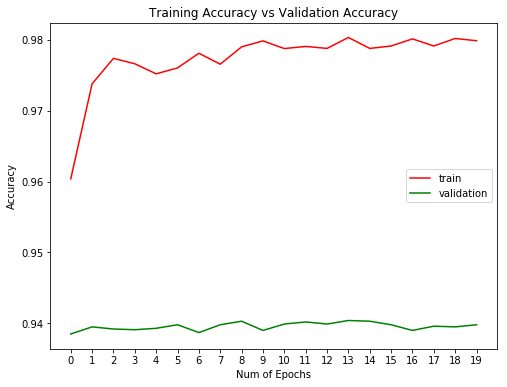

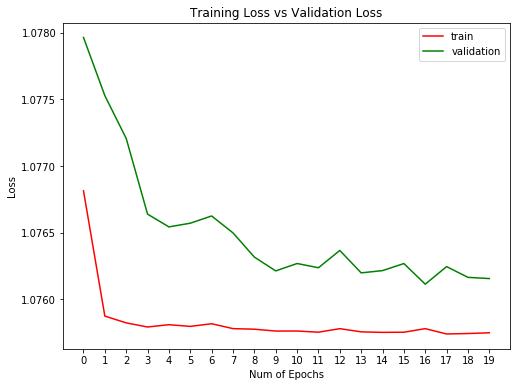

In [10]:
history = model_handle.model.history

plt.figure(0)
plt.plot(history.history['acc'],'r')
plt.plot(history.history['val_acc'],'g')
plt.xticks(np.arange(0, 20, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 20, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
 
plt.show()

In [11]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Y_train = keras.utils.to_categorical(y_train, 10)
Y_test = keras.utils.to_categorical(y_test, 10)
results = model_handle.predict(x=X_test)

In [12]:
boolarr = (np.argmax(results, axis=1) == y_test.reshape(-1))
print ('Correct %d/%d' % (np.sum(boolarr), X_test.shape[0]), '(Accuracy: %f)'% (np.sum(boolarr)/X_test.shape[0]))

Correct 9398/10000 (Accuracy: 0.939800)


[[951   1  13   5   1   0   2   0  19   8]
 [  4 975   1   0   0   0   0   0   5  15]
 [ 19   0 918  17  16   8  13   5   4   0]
 [  5   1  16 895  12  50  12   5   3   1]
 [  5   0  12  14 949  11   4   5   0   0]
 [  4   1   9  74  15 886   3   7   0   1]
 [  5   0  12  20   1   3 959   0   0   0]
 [  4   0   9   6   9  13   0 957   1   1]
 [ 18   4   3   3   0   0   2   0 962   8]
 [  6  34   1   4   0   0   2   0   7 946]]


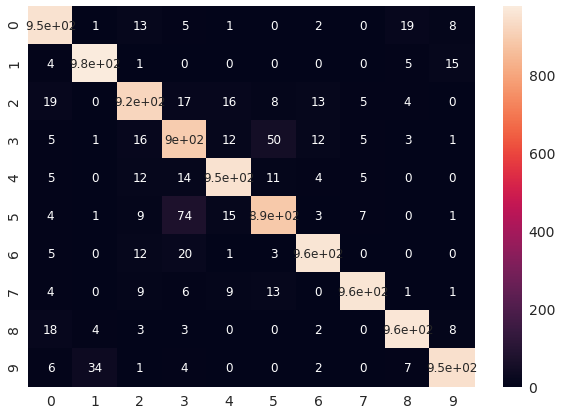

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = np.argmax(results, axis=1).reshape(10000,1)

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd

df_cm = pd.DataFrame(cm, range(10), range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff815ec6550>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff815f3c908>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff815ec66d8>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff815f3c400>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff815f32d30>],
 'means': []}

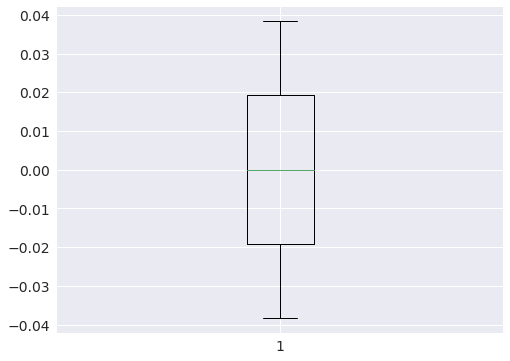

In [15]:
layer = model_handle.model.get_layer('binary_dense_22')
layer.get_weights()
plt.boxplot(layer.get_weights()[0].reshape(-1))

# Binarization

In [17]:
model_handle = VGGbinarized_cifar10(train=False, weights_path='saved_models/VGGbinarized_cifar10_model.020-0.94.h5')
model_handle.model.summary()

Trained weights saving path  /root/workspace/bnn_p4/BaNaNa-split-binarization/binarized/saved_models/VGGbinarized_cifar10_model.{epoch:03d}-{val_acc:.2f}.h5
Loading weights from  saved_models/VGGbinarized_cifar10_model.020-0.94.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40_input (InputLayer) (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_57 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_31 (Dropout)         (None, 32, 32, 64)        0         
___________________________________________

In [18]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Y_train = keras.utils.to_categorical(y_train, 10)
Y_test = keras.utils.to_categorical(y_test, 10)
results = model_handle.predict(x=X_test)

In [19]:
boolarr = (np.argmax(results, axis=1) == y_test.reshape(-1))
print ('Correct %d/%d' % (np.sum(boolarr), X_test.shape[0]), '(Accuracy: %f)'% (np.sum(boolarr)/X_test.shape[0]))

Correct 9407/10000 (Accuracy: 0.940700)


In [20]:
from binary_ops import xnorize # import binarization funciton

def get_binarized_params(W):
    temp_tensor = K.variable(W)
    (Wa, Wb) = xnorize(W=temp_tensor)
    return K.eval(Wb)

l1 = get_binarized_params(model_handle.model.get_layer('binary_dense_26').get_weights()[0])
l2 = get_binarized_params(model_handle.model.get_layer('binary_dense_28').get_weights()[0])
l3 = get_binarized_params(model_handle.model.get_layer('binary_dense_30').get_weights()[0])

In [21]:
l1, l2, l3

(array([[ 1., -1., -1., ..., -1., -1.,  1.],
        [-1., -1.,  1., ..., -1.,  1., -1.],
        [ 1., -1.,  1., ..., -1.,  1.,  1.],
        ...,
        [ 1.,  1., -1., ...,  1., -1., -1.],
        [-1.,  1.,  1., ..., -1., -1., -1.],
        [ 1., -1., -1., ..., -1., -1.,  1.]], dtype=float32),
 array([[-1., -1.,  1., ...,  1., -1., -1.],
        [-1., -1., -1., ...,  1.,  1., -1.],
        [-1., -1.,  1., ...,  1.,  1., -1.],
        ...,
        [-1.,  1.,  1., ...,  1.,  1., -1.],
        [ 1., -1., -1., ...,  1., -1., -1.],
        [ 1.,  1., -1., ..., -1.,  1., -1.]], dtype=float32),
 array([[-1.,  1.,  1., ..., -1., -1., -1.],
        [ 1., -1., -1., ...,  1., -1., -1.],
        [-1.,  1., -1., ..., -1., -1.,  1.],
        ...,
        [ 1.,  1., -1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [-1., -1.,  1., ..., -1., -1., -1.]], dtype=float32))

In [23]:
model_handle.model.get_layer('binary_dense_26').set_weights(weights=[l1])
model_handle.model.get_layer('binary_dense_28').set_weights(weights=[l2])
model_handle.model.get_layer('binary_dense_30').set_weights(weights=[l3])

In [24]:
results = model_handle.predict(x=X_test)

In [25]:
boolarr = (np.argmax(results, axis=1) == y_test.reshape(-1))
print ('Correct %d/%d' % (np.sum(boolarr), X_test.shape[0]), '(Accuracy: %f)'% (np.sum(boolarr)/X_test.shape[0]))

Correct 9407/10000 (Accuracy: 0.940700)


# Acks

This notebook uses code from and inspired by [1] for the VGG16 version for cifar10, and [2] for the binarized layers implementation.

[1] https://github.com/geifmany/cifar-vgg 
[2] https://github.com/DingKe/BinaryNet